In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)  # Shows all columns


In [20]:
df = pd.read_csv("wnba_pregancy_analysis.csv")
df

df['SEASON_ID'] = df['SEASON_ID'].str.slice(0, 4)
df['SEASON_ID'] = df['SEASON_ID'].astype(int)

# Display the DataFrame to verify
print(df[['Player', 'SEASON_ID']].head())


                 Player  SEASON_ID
0  Skylar Diggins-Smith       2013
1  Skylar Diggins-Smith       2014
2  Skylar Diggins-Smith       2015
3  Skylar Diggins-Smith       2016
4  Skylar Diggins-Smith       2017


In [21]:
# Identify missing years per player
all_seasons = list(range(df["SEASON_ID"].min(), df["SEASON_ID"].max() + 1))

new_rows = []

for player in df["Player"].unique():
    player_data = df[df["Player"] == player]
    existing_seasons = set(player_data["SEASON_ID"])
    missing_seasons = set(all_seasons) - existing_seasons

    for missing_year in sorted(missing_seasons):
        # Find the closest previous year's data
        previous_data = player_data[player_data["SEASON_ID"] < missing_year].sort_values("SEASON_ID", ascending=False)

        if not previous_data.empty:
            new_row = previous_data.iloc[0].copy()
            new_row["SEASON_ID"] = missing_year  # Assign missing year
            new_rows.append(new_row)

# Append new rows to dataframe
df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True).sort_values(["Player", "SEASON_ID"])


In [22]:
# Ensure SEASON_ID is in the correct integer format

# Add a new column for pregnancy status
def get_pregnancy_status(row):
    player = row['Player']
    season = row['SEASON_ID']

    # Define pregnancy status based on player and season
    if player == 'Skylar Diggins-Smith':
        if season == 2019:
            return 'Pregnant'
        elif season == 2023:
            return 'Pregnant'
        else:
            return 'Pre-pregnant' if season < 2018 else 'Post-pregnant'
        
    elif player == 'Dearica Hamby':
        if season == 2017:
            return 'Pregnant'
        elif season == 2023:
            return 'Pregnant'
        else:
            return 'Pre-pregnant' if season < 2017 else 'Post-pregnant'


    elif player == 'DeWanna Bonner':
        if season == 2017:
            return 'Pregnant'
        elif season > 2017:
            return 'Post-pregnant'
        else:
            return 'Pre-pregnant'
    
    return 'Pre-pregnant'  # Default to 'Pre-pregnant' for any other cases

# Apply the function to each row in the DataFrame
df['Pregnancy_Status'] = df.apply(get_pregnancy_status, axis=1)

# Display the DataFrame to verify
df.head(5)


,Player,Player_ID,SEASON_ID,League_id,Team_id,Team_Abbreviation,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,Pregnancy_Status
20,DeWanna Bonner,201886,2009,10,1611661317,PHO,22.0,34,0,724,127,278,0.457,2,13,0.154,125,154,0.812,70,126,196,13,23,25,34,70,381,Pre-pregnant
21,DeWanna Bonner,201886,2010,10,1611661317,PHO,23.0,32,4,813,132,284,0.465,19,53,0.358,100,119,0.840,67,129,196,40,22,37,41,58,383,Pre-pregnant
22,DeWanna Bonner,201886,2011,10,1611661317,PHO,24.0,34,5,857,120,279,0.430,35,102,0.343,90,99,0.909,62,176,238,27,34,36,34,61,365,Pre-pregnant
23,DeWanna Bonner,201886,2012,10,1611661317,PHO,25.0,32,32,1120,212,582,0.364,52,184,0.283,184,216,0.852,55,175,230,71,54,28,75,46,660,Pre-pregnant
24,DeWanna Bonner,201886,2013,10,1611661317,PHO,26.0,34,33,1119,160,390,0.410,54,166,0.325,118,131,0.901,35,163,198,82,39,11,56,45,492,Pre-pregnant


In [23]:
# calculate efficiency of player by this formula: (PTS + REB + AST + STL + BLK − Missed FG − Missed FT - TO) / GP 
# it was formulated by Martin Manley

df['EFF'] = (
    (df['PTS'] +
     df['REB'] +
     df['AST'] +
     df['STL'] +
     df['BLK'] -
     (df['FGA'] - df['FGM']) -  # Missed FG
     (df['FTA'] - df['FTM']) -  # Missed FT
     df['TOV']) /
    df['GP']
)

print(df[['Player', 'SEASON_ID', 'EFF']])


                  Player  SEASON_ID        EFF
20        DeWanna Bonner       2009  12.470588
21        DeWanna Bonner       2010  14.562500
22        DeWanna Bonner       2011  14.647059
23        DeWanna Bonner       2012  17.687500
24        DeWanna Bonner       2013  15.382353
25        DeWanna Bonner       2014  12.235294
26        DeWanna Bonner       2015  16.454545
27        DeWanna Bonner       2016  15.382353
37        DeWanna Bonner       2017  15.382353
28        DeWanna Bonner       2018  19.852941
29        DeWanna Bonner       2019  18.264706
30        DeWanna Bonner       2020  20.545455
31        DeWanna Bonner       2021  16.750000
32        DeWanna Bonner       2022  14.363636
33        DeWanna Bonner       2023  16.925000
34        DeWanna Bonner       2024  15.350000
10         Dearica Hamby       2015   5.258065
11         Dearica Hamby       2016   9.040000
12         Dearica Hamby       2017   8.117647
13         Dearica Hamby       2018   9.090909
14         De

In [ ]:
## based on these plots, it looks like these wnba players were not affected by pregnancy. see if defensive and offensive efficiency rating effects things

# Estimate possessions
df['Possessions'] = df['FGA'] + 0.44 * df['FTA'] - df['OREB'] + df['TOV']

# Calculate Offensive Efficiency Rating (OER)
df['OER'] = (df['PTS'] * 100) / df['Possessions']

# Calculate Defensive Impact Score as a proxy for Defensive Efficiency
df['DER'] = (df['DREB'] + df['STL'] + df['BLK']) / df['Possessions'] * 100

# Display the updated DataFrame with DER
print(df[['Player', 'SEASON_ID', 'OER', 'DER', 'Pregnancy_Status']])

                  Player  SEASON_ID         OER        DER Pregnancy_Status
20        DeWanna Bonner       2009  122.998450  56.172521     Pre-pregnant
21        DeWanna Bonner       2010  123.405078  60.574816     Pre-pregnant
22        DeWanna Bonner       2011  123.913634  83.514394     Pre-pregnant
23        DeWanna Bonner       2012   94.686101  36.870194     Pre-pregnant
24        DeWanna Bonner       2013  104.984636  45.450666     Pre-pregnant
25        DeWanna Bonner       2014  105.993274  50.444391     Pre-pregnant
26        DeWanna Bonner       2015   98.324149  41.896278     Pre-pregnant
27        DeWanna Bonner       2016  109.110263  45.462610     Pre-pregnant
37        DeWanna Bonner       2017  109.110263  45.462610         Pregnant
28        DeWanna Bonner       2018  111.490330  48.729617    Post-pregnant
29        DeWanna Bonner       2019   98.075376  48.786212    Post-pregnant
30        DeWanna Bonner       2020  102.464822  44.149589    Post-pregnant
31        De

In [29]:
df.to_excel("wnba_pregnancy_final.xlsx")

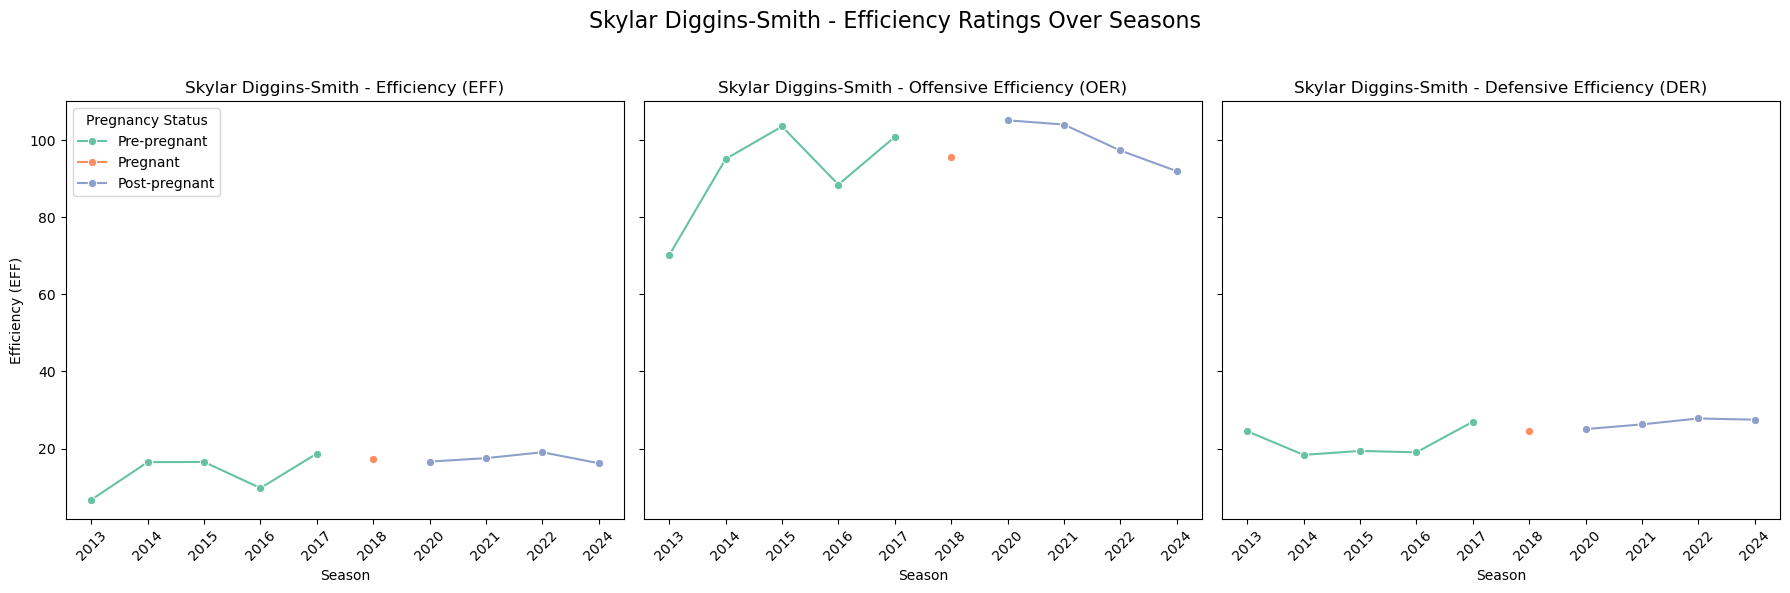

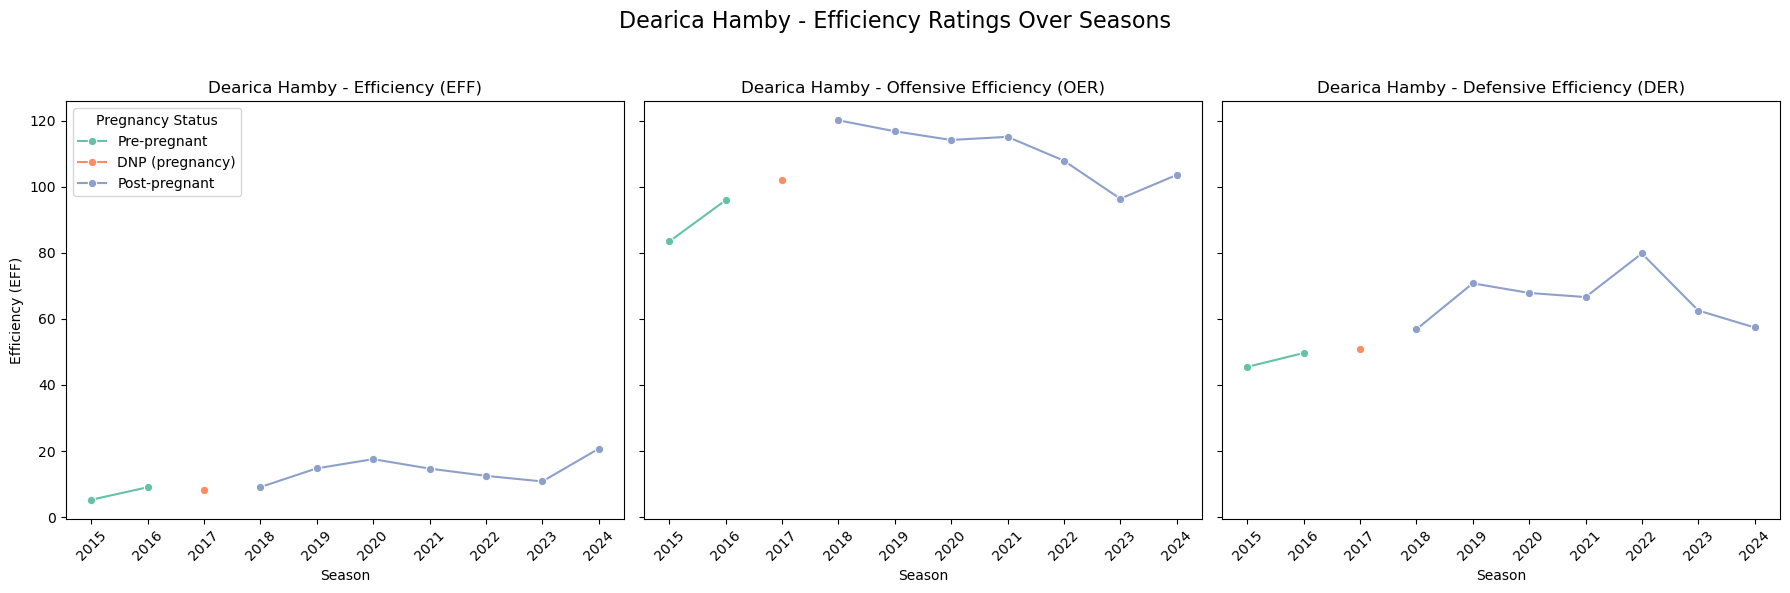

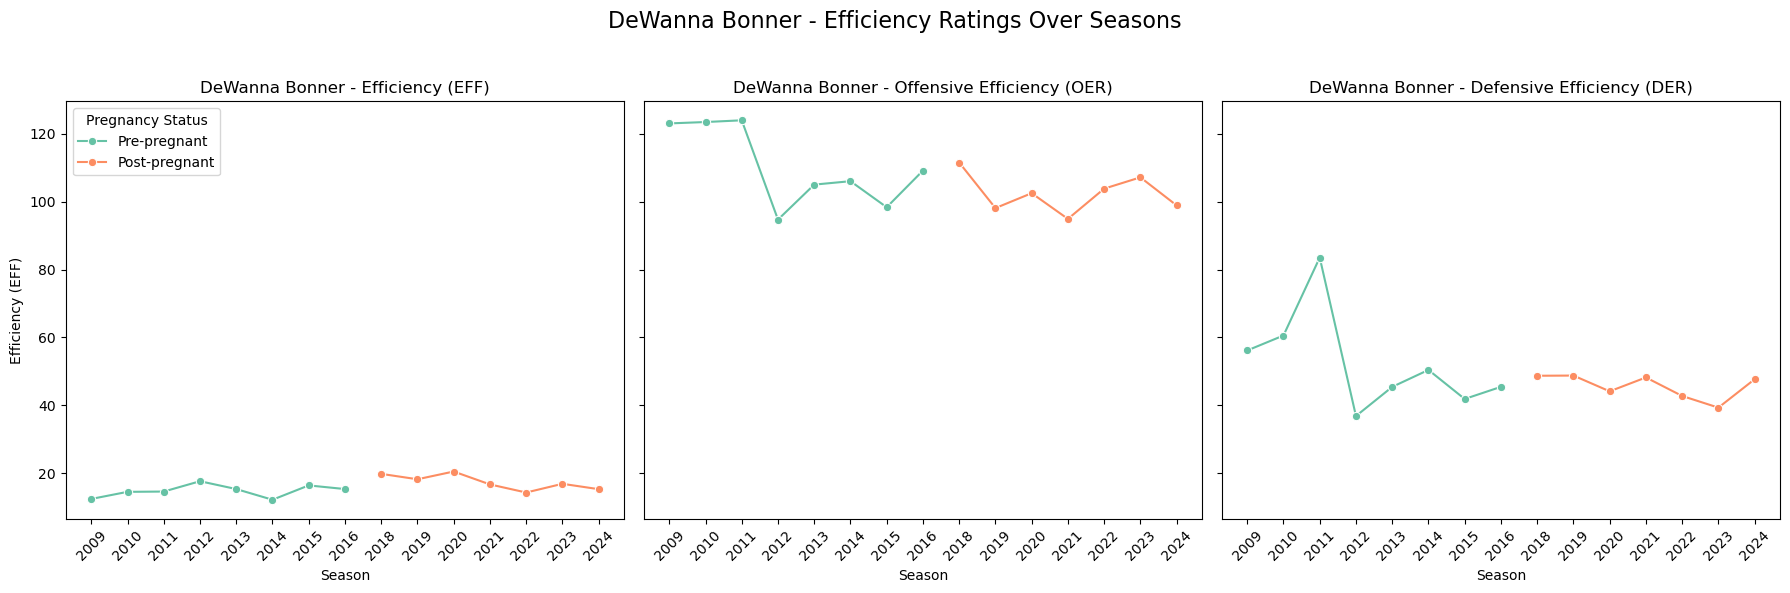

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure SEASON_ID is treated as a string for labeling
df['SEASON_ID'] = df['SEASON_ID'].astype(str)

# Loop through each unique player and generate side-by-side line plots
for player in df['Player'].unique():
    # Filter data for the current player
    player_data = df[df['Player'] == player]
    
    # Set up a subplot with 1 row and 3 columns for EFF, OER, and DER
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Plot EFF for each season
    sns.lineplot(
        data=player_data,
        x='SEASON_ID',
        y='EFF',
        hue='Pregnancy_Status',
        marker='o',
        ax=axes[0],
        palette='Set2'
    )
    axes[0].set_title(f'{player} - Efficiency (EFF)')
    axes[0].set_xlabel('Season')
    axes[0].set_ylabel('Efficiency (EFF)')
    axes[0].legend(title='Pregnancy Status', loc='upper left')
    axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Plot OER for each season
    sns.lineplot(
        data=player_data,
        x='SEASON_ID',
        y='OER',
        hue='Pregnancy_Status',
        marker='o',
        ax=axes[1],
        palette='Set2'
    )
    axes[1].set_title(f'{player} - Offensive Efficiency (OER)')
    axes[1].set_xlabel('Season')
    axes[1].set_ylabel('Offensive Efficiency (OER)')
    axes[1].legend().remove()  # Remove legend to avoid repetition
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Plot DER for each season
    sns.lineplot(
        data=player_data,
        x='SEASON_ID',
        y='DER',
        hue='Pregnancy_Status',
        marker='o',
        ax=axes[2],
        palette='Set2'
    )
    axes[2].set_title(f'{player} - Defensive Efficiency (DER)')
    axes[2].set_xlabel('Season')
    axes[2].set_ylabel('Defensive Efficiency (DER)')
    axes[2].legend().remove()  # Remove legend to avoid repetition
    axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

    # Adjust layout and display the plots
    plt.suptitle(f'{player} - Efficiency Ratings Over Seasons', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()
